In [1]:
# Import important libs
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader
from surprise import SVD
import emoji
import pickle
import re
import nltk
import string
# from surprise import evaluate
from surprise import Dataset
from surprise.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rake_nltk import Rake
from nltk.tokenize import word_tokenize


import warnings; warnings.simplefilter('ignore')

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sudeepsawant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sudeepsawant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/sudeepsawant/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sudeepsawant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
movie_df = pd. read_csv('data/movies_metadata.csv')
movie_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
movie_df['original_title']=movie_df['original_title'].str.lower() 
movie_df['original_title']

0                          toy story
1                            jumanji
2                   grumpier old men
3                  waiting to exhale
4        father of the bride part ii
                    ...             
45461                        رگ خواب
45462            siglo ng pagluluwal
45463                       betrayal
45464            satana likuyushchiy
45465                       queerama
Name: original_title, Length: 45466, dtype: object

In [5]:
# Selecting all the genres 

movie_df['genres'] = movie_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [6]:
# get movie release year
movie_df['year'] = pd.to_datetime(movie_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [7]:
# Evl Vote count 

vote_count = movie_df[movie_df['vote_count'].notnull()]['vote_count'].astype('int')

vote_avg = movie_df[movie_df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_avg.mean()
C

5.244896612406511

In [8]:
m = vote_count.quantile(0.95)
m

434.0

In [9]:
qualified = movie_df[(movie_df['vote_count'] >= m) & (movie_df['vote_count'].notnull()) & (movie_df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [10]:
def weighted_ratings(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [11]:
qualified['weighted_rating'] = qualified.apply(weighted_ratings, axis=1)

In [12]:
qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)

In [13]:
qualified.head(1)

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588


In [14]:
s = movie_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_movie_df = movie_df.drop('genres', axis=1).join(s)


In [15]:
def build_chart(genre, percentile=0.85):
    df = gen_movie_df[gen_movie_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [16]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


## Content Based Recommender System

In [17]:
links_small = pd.read_csv('data/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [18]:
movie_df = movie_df.drop([19730, 29503, 35587])


In [19]:
#Check EDA Notebook for how and why I got these indices.
movie_df['id'] = movie_df['id'].astype('int')

In [20]:
#Check EDA Notebook for how and why I got these indices.
movie_df['id'] = movie_df['id'].astype('int')

In [21]:
movie_df_ex = movie_df[movie_df['id'].isin(links_small)]
movie_df_ex.shape

(9099, 25)

In [22]:
movie_df_ex['tagline'].head(10)

0                                                  NaN
1            Roll the dice and unleash the excitement!
2    Still Yelling. Still Fighting. Still Ready for...
3    Friends are the people who let you be yourself...
4    Just When His World Is Back To Normal... He's ...
5                             A Los Angeles Crime Saga
6    You are cordially invited to the most surprisi...
7                               The Original Bad Boys.
8                           Terror goes into overtime.
9                 No limits. No fears. No substitutes.
Name: tagline, dtype: object

## Tags based Recommender System

In [23]:
movie_df_ex['tagline'] = movie_df_ex['tagline'].fillna('')
movie_df_ex['description'] = movie_df_ex['overview'] + movie_df_ex['tagline']
movie_df_ex['description'] = movie_df_ex['description'].fillna('')

In [24]:
movie_df_ex = movie_df_ex.sort_values('title', ascending=False).drop_duplicates('title').sort_index()

In [25]:
from nltk.corpus import stopwords
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
words = set(nltk.corpus.words.words())

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# clean the text dataframe
def text_cleaning(text):
    text = text.lower()
        
    text = re.sub(r'http.?:\/\/\S+','',text) #remove links
    text = emoji.demojize(text, delimiters=("", "")) 
  # text = text.encode("ascii", errors="ignore").decode()
 
    text=re.sub(r'@[A-Za-z0-9]+','',text) #removes mentions
    text=re.sub(r'#','',text)#remove hashtag
    text = re.sub(r'RT[\s]','',text) #remove RT
    text = re.sub(r'http?:\/\/\S+','',text) #remove links
    text = re.sub(r"br", " ", text)
    text = re.sub(r"_", " ", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", " ", text)
    text = re.sub(r'\'','',text)
    text = re.sub(r'\"','',text)
    text = re.sub(r'\“','',text)
    text = re.sub(r'\”','',text)
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words1 = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    stop_words.discard("not")

    words1 = [w for w in words1 if not w in stop_words]
    words1 = ' '.join(words1)
  # print(words1)
  # words1 = " ".join(w for w in nltk.wordpunct_tokenize(words1) if w.lower() in words or not w.isalpha())
  # words1 = [w for w in words1 if  w in words.words()]
  # final = ' '.join(words1)
    final=[lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(words1)]
    final = ' '.join(final)
    return final

In [26]:
movie_df_ex['description'] = movie_df_ex['description'].apply(text_cleaning)

In [27]:
# movie_df_ex.to_csv('tags_recom.csv',index=False)

In [28]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
c = CountVectorizer()
tfidf_mtx = c.fit_transform(movie_df_ex['description'])

In [29]:
tfidf_mtx.shape

(8809, 26799)

In [30]:
cosine_sim = linear_kernel(tfidf_mtx, tfidf_mtx)

In [31]:
cosine_sim[0]

array([51.,  1.,  0., ...,  1.,  0.,  1.])

In [32]:
movie_df_ex

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,description
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,toy story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,led woody andy toy live happily room andy birt...
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,sibling judy peter discover enchanted board ga...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,grumpier old men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,family wedding reignites ancient feud next doo...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,waiting to exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,cheated mistreated stepped woman holding eath ...
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,father of the bride part ii,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,george bank recovered daughter wedding receive...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40058,False,NaN,15050000,"[Adventure, Drama, History, Romance]",NaN,402672,tt3859980,hi,mohenjo daro,"Village lad Sarman is drawn to big, bad Mohenj...",...,155.0,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,,Mohenjo Daro,False,6.7,26.0,2016,village lad sarman drawn big bad mohenjo daro ...
40224,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,...,120.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,A god incarnate. A city doomed.,Shin Godzilla,False,6.6,152.0,2016,mind behind evangelion come hit larger life ma...
40503,False,NaN,0,"[Documentary, Music]",http://www.thebeatlesliveproject.com/,391698,tt2531318,en,the beatles: eight days a week - the touring y...,"The band stormed Europe in 1963, and, in 1964,...",...,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The band you know. The story you don't.,The Beatles: Eight Days a Week - The Touring Y...,False,7.6,92.0,2016,band stormed europe conquered america ground e...
44821,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",16000000,"[Adventure, Fantasy, Animation, Action, Family]",http://movies.warnerbros.com/pk3/,10991,tt0235679,ja,pokémon 3: the movie,When Molly Hale's sadness of her father's disa...,...,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pokémon: Spell of the Unknown,Pokémon: Spell of the Unknown,False,6.0,144.0,2000,molly hale sadness father disappearance get un...


In [33]:
movie_df_ex.to_csv('tags_recom.csv',index=False)

In [34]:
# movie_df_ex=movie_df_ex.drop(['level_0', 'index'], axis=1)

In [35]:
movie_df_ex = movie_df_ex.reset_index()
titles = movie_df_ex['title']
indices = pd.Series(movie_df_ex.index, index=movie_df_ex['title'])

In [36]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
c  = CountVectorizer()
tfidf_mtx = c.fit_transform(movie_df_ex['description'])
cosine_sim = linear_kernel(tfidf_mtx, tfidf_mtx)
movie_df_ex = movie_df_ex.reset_index()
titles = movie_df_ex['title']
indices = pd.Series(movie_df_ex.index, index=movie_df_ex['title'])
def recommendations_tags(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [37]:
recommendations_tags('2012').head(10)

6041                        Left Behind III: World at War
4898                                           Cool World
4399                                             The Core
7787                 Dragon Ball Z: The World's Strongest
1208                                         Men in Black
6893                                                Ponyo
6990    Fullmetal Alchemist the Movie: Conqueror of Sh...
59                                               Bio-Dome
5408                           Team America: World Police
6761                                           Death Note
Name: title, dtype: object

In [38]:
recommendations_tags('Inception').head(10)

3877    Y Tu Mamá También
7132             Precious
7379           Seven Days
7880                56 Up
160               The Net
4287          American Me
7860          Holy Motors
8235        Gerontophilia
539          Carried Away
1904           Tough Guys
Name: title, dtype: object

## Metadata - Content Based Recommender

In [39]:
credits = pd.read_csv('data/credits.csv')
keywords = pd.read_csv('data/keywords.csv')

In [40]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movie_df['id'] = movie_df['id'].astype('int')

In [41]:
movie_df.shape

(45463, 25)

In [42]:
movie_df = movie_df.merge(credits, on='id')
movie_df = movie_df.merge(keywords, on='id')

In [43]:
smovie_df = movie_df[movie_df['id'].isin(links_small)]
smovie_df.shape

(9219, 28)

In [44]:
smovie_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,toy story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,grumpier old men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,waiting to exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,father of the bride part ii,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

Crew: From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.
Cast: Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [45]:
smovie_df['cast'] = smovie_df['cast'].apply(literal_eval)
smovie_df['crew'] = smovie_df['crew'].apply(literal_eval)
smovie_df['keywords'] = smovie_df['keywords'].apply(literal_eval)
smovie_df['cast_size'] = smovie_df['cast'].apply(lambda x: len(x))
smovie_df['crew_size'] = smovie_df['crew'].apply(lambda x: len(x))

In [46]:
def get_directors(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [47]:
smovie_df['director'] = smovie_df['crew'].apply(get_directors)

In [48]:
smovie_df['cast'] = smovie_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smovie_df['cast'] = smovie_df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [49]:
smovie_df['keywords'] = smovie_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

These are steps I follow in the preparation of my genres and credits data:

Strip Spaces and Convert to Lowercase from all our features. This way, our engine will not confuse between Johnny Depp and Johnny Galecki.
Mention Director 3 times to give it more weight relative to the entire cast.

In [50]:
smovie_df['cast'] = smovie_df['cast'].apply(lambda x: [str.lower(i.replace(" ", " ")) for i in x])

In [51]:
smovie_df['director'] = smovie_df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", " ")))
smovie_df['director'] = smovie_df['director'].apply(lambda x: [x,x, x])

Keywords


We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [52]:
s = smovie_df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [53]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [54]:
s = s[s > 1]

In [55]:
# stemmer = SnowballStemmer('english')
# stemmer.stem('dogs')

In [56]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [57]:
smovie_df['keywords'] = smovie_df['keywords'].apply(filter_keywords)
# smovie_df['keywords'] = smovie_df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smovie_df['keywords'] = smovie_df['keywords'].apply(lambda x: [str.lower(i.replace(" ", " ")) for i in x])

In [58]:
smovie_df['soup'] = smovie_df['keywords'] + smovie_df['cast'] + smovie_df['director'] + smovie_df['genres']
smovie_df['soup'] = smovie_df['soup'].apply(lambda x: ' '.join(x))

In [59]:
smovie_df['soup'][0]

'jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life tom hanks tim allen don rickles john lasseter john lasseter john lasseter Animation Comedy Family'

In [60]:
smovie_df = smovie_df.sort_values('title', ascending=False).drop_duplicates('title').sort_index()

In [61]:
smovie_df.to_csv('content_recom.csv',index=False)

In [62]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smovie_df['soup'])

In [63]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [64]:
smovie_df = smovie_df.reset_index()
titles = smovie_df['title']
indices = pd.Series(smovie_df.index, index=smovie_df['title'])

In [65]:
# get_recommendations('Back to the Future').head(10)

Popularity and Ratings

I will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of  m
 , we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [66]:
smovie_df.head()

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director,soup
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,toy story,...,7.7,5415.0,1995,"[tom hanks, tim allen, don rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,"[john lasseter, john lasseter, john lasseter]",jealousy toy boy friendship friends rivalry bo...
1,1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,jumanji,...,6.9,2413.0,1995,"[robin williams, jonathan hyde, kirsten dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,"[joe johnston, joe johnston, joe johnston]",board game disappearance based on children's b...
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,grumpier old men,...,6.5,92.0,1995,"[walter matthau, jack lemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger]",7,4,"[howard deutch, howard deutch, howard deutch]",fishing best friend duringcreditsstinger walte...
3,3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,waiting to exhale,...,6.1,34.0,1995,"[whitney houston, angela bassett, loretta devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,"[forest whitaker, forest whitaker, forest whit...",based on novel interracial relationship single...
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,father of the bride part ii,...,5.7,173.0,1995,"[steve martin, diane keaton, martin short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,"[charles shyer, charles shyer, charles shyer]",baby midlife crisis confidence aging daughter ...


In [67]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smovie_df['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
smovie_df = smovie_df.reset_index()
titles = smovie_df['title']
indices = pd.Series(smovie_df.index, index=smovie_df['title'])

In [68]:


def recommendations_content(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smovie_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [69]:
# #Tokenization of text
# tokenizer=ToktokTokenizer()
# #Setting English stopwords
# stopword_list=nltk.corpus.stopwords.words('english')

In [70]:
# def txt_clean(text):
#     text = strip_html(text)
#     text = remove_between_square_brackets(text)
#     text = remove_special_characters(text)
#     text = simple_stemmer(text)
#     text = remove_stopwords(text)
#     print(text)
# #     text = simple_stemmer(text)
#     op = cv.transform(norm_test_reviews)
#     return op


    
    

In [71]:

#Apply function on review column
# imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [72]:
# #Define function for removing special characters
# def remove_special_characters(text, remove_digits=True):
#     pattern=r'[^a-zA-z0-9\s]'
#     text=re.sub(pattern,'',text)
#     return text
# #Apply function on review column
# imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

In [73]:
# #Stemming the text
# def simple_stemmer(text):
#     ps=nltk.porter.PorterStemmer()
#     text= ' '.join([ps.stem(word) for word in text.split()])
#     return text
# #Apply function on review column
# imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [74]:
# #set stopwords to english
# stop=set(stopwords.words('english'))
# print(stop)

# #removing the stopwords
# def remove_stopwords(text, is_lower_case=False):
#     tokens = tokenizer.tokenize(text)
#     tokens = [token.strip() for token in tokens]
#     if is_lower_case:
#         filtered_tokens = [token for token in tokens if token not in stopword_list]
#     else:
#         filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
#     filtered_text = ' '.join(filtered_tokens)    
#     return filtered_text
# #Apply function on review column
# imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

In [75]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+434.0) * R) + (434.0/(434.0+v) * 5.244896612406511)

In [76]:
movie_df_ex.to_csv('tags_data.csv',index=False)

In [77]:
recommendations_content('2 Fast 2 Furious').head(10)

,title,vote_count,vote_average,year,wr
8551,Furious 7,4253,7,2015,6.837483
945,The Blues Brothers,1092,7,1980,6.500842
8042,Fast & Furious 6,5282,6,2013,5.942667
6211,Cars,3991,6,2006,5.925940
6955,Fast & Furious,2426,6,2009,5.885414
6232,The Fast and the Furious: Tokyo Drift,1749,6,2006,5.849879
1206,Face/Off,1612,6,1997,5.839827
2871,Gone in Sixty Seconds,1511,6,2000,5.831509
5982,Four Brothers,617,6,2005,5.688188
7643,Abduction,987,5,2011,5.074796


## Collaborative based Recommender System

In [78]:
import pandas as pd
from scipy import sparse

In [79]:
ratings = pd.read_csv('dataset/ratings.csv')
movies = pd.read_csv('dataset/movies.csv')

In [80]:
movies['title']=movies['title'].str.replace(r" \(.*\)","")
movies['title']=movies['title'].str.lower()

In [81]:

ratings = pd.merge(movies,ratings).drop(['genres','timestamp'],axis=1)
print(ratings.shape)
ratings.head()

(100836, 4)


,movieId,title,userId,rating
0,1,toy story,1,4.0
1,1,toy story,5,4.0
2,1,toy story,7,4.5
3,1,toy story,15,2.5
4,1,toy story,17,4.5


In [82]:
userRatings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
userRatings.head()
print("Before: ",userRatings.shape)
userRatings = userRatings.dropna(thresh=10, axis=1).fillna(0,axis=1)
#userRatings.fillna(0, inplace=True)
print("After: ",userRatings.shape)

Before:  (610, 9396)
After:  (610, 2260)


In [83]:
userRatings.to_csv('ratings.csv',index=False)

In [84]:
userRatings.head()

title,"'burbs, the",(500) days of summer,10 cloverfield lane,10 things i hate about you,"10,000 bc",101 dalmatians,12 angry men,12 years a slave,127 hours,13 going on 30,...,young guns ii,young sherlock holmes,zack and miri make a porno,zero dark thirty,zero effect,zodiac,zombieland,zoolander,zootopia,¡three amigos!
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:

corrMatrix = userRatings.corr(method='pearson')
corrMatrix.head(100)

title,"'burbs, the",(500) days of summer,10 cloverfield lane,10 things i hate about you,"10,000 bc",101 dalmatians,12 angry men,12 years a slave,127 hours,13 going on 30,...,young guns ii,young sherlock holmes,zack and miri make a porno,zero dark thirty,zero effect,zodiac,zombieland,zoolander,zootopia,¡three amigos!
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, the",1.000000,0.063117,-0.023768,0.143482,0.011998,0.169190,0.034133,0.009277,0.008331,0.049700,...,0.088114,0.257195,0.017477,0.032470,0.134701,0.153158,0.101301,0.049897,0.003233,0.353194
(500) days of summer,0.063117,1.000000,0.142471,0.273989,0.193960,0.158751,0.160679,0.135486,0.200135,0.297152,...,0.053263,0.053021,0.374515,0.178655,0.068407,0.414585,0.355723,0.252226,0.216007,0.125905
10 cloverfield lane,-0.023768,0.142471,1.000000,-0.005799,0.112396,0.002605,0.031619,-0.024275,0.272943,-0.027835,...,0.048452,0.028247,0.242663,0.099059,-0.023477,0.272347,0.241751,0.195054,0.319371,0.002733
10 things i hate about you,0.143482,0.273989,-0.005799,1.000000,0.244670,0.256865,0.013083,0.091964,0.043383,0.321071,...,0.045664,0.087961,0.243118,0.104858,0.132460,0.091853,0.158637,0.281934,0.050031,0.110612
"10,000 bc",0.011998,0.193960,0.112396,0.244670,1.000000,0.231937,0.059068,-0.025882,0.089328,0.167098,...,0.028153,0.040140,0.260261,0.087592,0.094913,0.184521,0.242299,0.240231,0.094773,0.083518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
amadeus,0.136013,0.084829,-0.055707,0.105783,-0.008620,0.108757,0.244597,0.084634,0.047370,0.089526,...,0.050400,0.122942,-0.010703,0.015008,0.173486,0.103232,0.062977,0.097432,-0.007432,0.136565
"amazing spider-man, the",0.083419,0.224961,0.149903,0.103802,0.278253,0.138029,0.072117,0.121492,0.168369,0.087661,...,0.096687,0.089827,0.350739,0.234351,0.089202,0.262828,0.409487,0.151747,0.373173,0.143658
amelie,0.062232,0.212394,0.006182,0.242019,0.151728,0.083751,0.149556,0.198445,0.087983,0.087940,...,-0.004763,-0.022172,0.117625,0.059183,0.033085,0.228739,0.101700,0.211782,0.035227,0.069898


In [86]:
def colab(movie_name,rating):
    userRatings = pd.read_csv('ratings.csv')
    corrMatrix = userRatings.corr(method='pearson')
#     corrMatrix.head(100)
    similar_movies = pd.DataFrame()
    similar_movies = corrMatrix[movie_name]*(float(rating) - 2.5)
    similar_movies = similar_movies.sort_values(ascending=False)
#     similar_movies = get_similar(movie_name,rating,corrMatrix).head(11) 
    similar_movies = similar_movies.to_frame()
    similar_movies = similar_movies.rename(index={0: "movies", 1: "sim"}).reset_index()
    # print(similar_movies.iloc[1:11,0:1])
    l = []
    for i in similar_movies['index'].iloc[0:11]:
        l.append(i)
    return l

In [87]:
print(colab('iron man',5))

['iron man', 'wall·e', 'dark knight, the', 'iron man 2', 'avengers, the', 'avatar', 'thor', 'star trek', 'watchmen', 'guardians of the galaxy', 'iron man 3']


## Sentiment analysis

In [88]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import spacy
from sklearn.naive_bayes import MultinomialNB
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


Init Plugin
Init Graph Optimizer
Init Kernel


In [89]:
#importing the training data
imdb_data=pd.read_csv('data/IMDBDataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [90]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


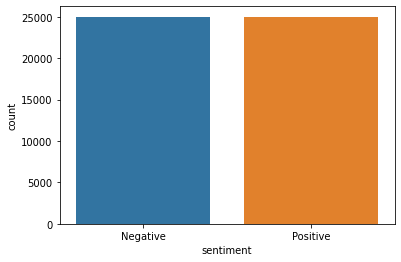

In [91]:
 # visualize the target variable
g = sns.countplot(imdb_data['sentiment'])
g.set_xticklabels(['Negative','Positive'])
plt.show()

##### Spliting the training dataset

In [92]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


### Text normalization

In [93]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
words = set(nltk.corpus.words.words())

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# clean the text dataframe
def text_cleaning(text):
    text = text.lower()
        
    text = re.sub(r'http.?:\/\/\S+','',text) #remove links
    text = emoji.demojize(text, delimiters=("", "")) 
  # text = text.encode("ascii", errors="ignore").decode()
 
    text=re.sub(r'@[A-Za-z0-9]+','',text) #removes mentions
    text=re.sub(r'#','',text)#remove hashtag
    text = re.sub(r'RT[\s]','',text) #remove RT
    text = re.sub(r'http?:\/\/\S+','',text) #remove links
    text = re.sub(r"br", " ", text)
    text = re.sub(r"_", " ", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", " ", text)
    text=re.sub(r'\'','',text)
    text=re.sub(r'\"','',text)
    text=re.sub(r'\“','',text)
    text=re.sub(r'\”','',text)
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words1 = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    stop_words.discard("not")

    words1 = [w for w in words1 if not w in stop_words]
    words1 = ' '.join(words1)
  # print(words1)
  # words1 = " ".join(w for w in nltk.wordpunct_tokenize(words1) if w.lower() in words or not w.isalpha())
  # words1 = [w for w in words1 if  w in words.words()]
  # final = ' '.join(words1)
    final=[lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(words1)]
    final = ' '.join(final)
    return final

In [94]:
imdb_data['review'] =  imdb_data['review'].apply(text_cleaning)

In [95]:

#Count vectorizer for bag of words
tfid=TfidfVectorizer(use_idf = True,lowercase = True, strip_accents='ascii',stop_words=stopwords.words('english'))
#transformed train reviews
test=imdb_data['review']
tfid_data_reviews=tfid.fit_transform(test)




In [96]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [97]:
X_train, X_test, y_train, y_test = train_test_split(tfid_data_reviews, sentiment_data, test_size=0.20, random_state=42)

In [98]:
pickle.dump(tfid, open('tfidfVector.pkl', 'wb'))

In [99]:
vectorizer = pickle.load(open('tranform.pkl','rb'))

In [100]:
tfid_data_reviews=vectorizer.fit_transform(test)

In [101]:
clf = MultinomialNB()
clf.fit(X_train,y_train)

MultinomialNB()

In [102]:
accuracy_score(y_test,clf.predict(X_test))*100

86.81

In [103]:
filename = 'nlp_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

<AxesSubplot:>

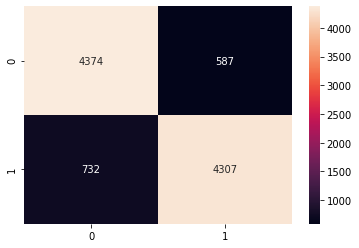

In [104]:
ypred=clf.predict(X_test)
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, ypred)

sns.heatmap(cm, annot=True,fmt='d')


In [105]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, ypred, average='binary')
print('precision:', precision)
print('recall:',recall)
print('f1score',f1score)

precision: 0.8800572129137719
recall: 0.8547330819607065
f1score 0.8672103090707742


In [106]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.86      0.88      0.87      4961
    negative       0.88      0.85      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [107]:
import pandas as pd
import numpy as np
import pandas as pd
from flask import Flask, render_template, request
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import json
import bs4 as bs
import urllib.request
import pickle
import requests
import Levenshtein




In [108]:
def similarity_tags():
    movie_df_ex = pd.read_csv('tags_recom.csv')
#     movie_df_ex=movie_df_ex.drop(['level_0', 'index'], axis=1)
    movie_df_ex['title']=movie_df_ex['title'].str.lower()
    tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
    c  = CountVectorizer()
    tfidf_mtx = c.fit_transform(movie_df_ex['description'].astype('U').values)
    cosine_sim = cosine_similarity(tfidf_mtx, tfidf_mtx)
    movie_df_ex = movie_df_ex.reset_index()
    titles = movie_df_ex['title']
    indices = pd.Series(movie_df_ex.index, index=movie_df_ex['title'])
    return movie_df_ex,indices,cosine_sim,titles
    
def recommendations_tags(title):    
#     m = title.lower()
    movie_df_ex,indices,cosine_sim,titles = similarity_tags()
#     print(movie_df_ex['title'].lower())
    if title not in movie_df_ex['title'].str.lower().unique():
        return('Sorry! The movie you requested is not in our database. Please check the spelling or try with some other movies')
    else:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        movie_indices = [i[0] for i in sim_scores]
        i = titles.iloc[movie_indices]
#         print(titles.iloc[movie_indices])
        l = []
        for i in titles.iloc[movie_indices]:
            l.append(i)
    return l

In [109]:
recommendations_tags('iron man')

['iron man 2',
 'street fighter',
 'iron man 3',
 'the spirit',
 'avengers: age of ultron',
 'igor',
 'scarface',
 'batman begins',
 'return from witch mountain',
 'dr. jekyll and mr. hyde']

In [110]:
def similarity_metadata():
    smovie_df = pd.read_csv('content_recom.csv')
#     smovie_df=smovie_df.drop(['level_0', 'index'], axis=1)
    smovie_df['title']=smovie_df['title'].str.lower()
    count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
    count_matrix = count.fit_transform(smovie_df['soup'])
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    smovie_df = smovie_df.reset_index()
    titles = smovie_df['title']
    indices = pd.Series(smovie_df.index, index=smovie_df['title'])
    return smovie_df,indices,cosine_sim,titles

In [111]:
def recommendations_content(title):    
    m = title.lower()
    smovie_df,indices,cosine_sim,titles = similarity_metadata()
    if title not in smovie_df['title'].str.lower().unique():
        return('Sorry! The movie you requested is not in our database. Please check the spelling or try with some other movies')
    else:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:26]
        movie_indices = [i[0] for i in sim_scores]

        movies = smovie_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
        vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
        vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
        C = vote_averages.mean()
        m = vote_counts.quantile(0.60)
        qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
        qualified['vote_count'] = qualified['vote_count'].astype('int')
        qualified['vote_average'] = qualified['vote_average'].astype('int')
        qualified['wr'] = qualified.apply(weighted_rating, axis=1)
        qualified = qualified.sort_values('wr', ascending=False).head(10)
#         print(titles.iloc[movie_indices])
#         print(qualified)
        l = []
        for i in qualified['title'].head(10):
            l.append(i)
    return l

In [112]:
recommendations_content('iron man')

['the avengers',
 'guardians of the galaxy',
 'captain america: civil war',
 'avengers: age of ultron',
 'ant-man',
 'captain america: the winter soldier',
 'iron man 3',
 'captain america: the first avenger',
 'iron man 2',
 'thor']

In [113]:
import scipy.stats

In [114]:
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
def similarity_metadata_sigmoid():
    smovie_df = pd.read_csv('content_recom.csv')
#     smovie_df=smovie_df.drop(['level_0', 'index'], axis=1)
    smovie_df['title']=smovie_df['title'].str.lower()
    count = TfidfVectorizer(strip_accents='unicode',analyzer='word',ngram_range=(1, 3),min_df=0, stop_words='english')
    count_matrix = count.fit_transform(smovie_df['soup'])
#     print(count_matrix[0])
    cosine_sim = sigmoid_kernel(count_matrix, count_matrix)
    smovie_df = smovie_df.reset_index()
    titles = smovie_df['title']
    indices = pd.Series(smovie_df.index, index=smovie_df['title'])
    return smovie_df,indices,cosine_sim,titles

In [115]:
def recommendations_content_sigmoid(title):    
    m = title.lower()
    smovie_df,indices,cosine_sim,titles = similarity_metadata_sigmoid()
    if title not in smovie_df['title'].str.lower().unique():
        return('Sorry! The movie you requested is not in our database. Please check the spelling or try with some other movies')
    else:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:26]
        movie_indices = [i[0] for i in sim_scores]

        movies = smovie_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
        vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
        vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
        C = vote_averages.mean()
        m = vote_counts.quantile(0.60)
        qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
        qualified['vote_count'] = qualified['vote_count'].astype('int')
        qualified['vote_average'] = qualified['vote_average'].astype('int')
        qualified['wr'] = qualified.apply(weighted_rating, axis=1)
        qualified = qualified.sort_values('wr', ascending=False).head(10)
#         print(titles.iloc[movie_indices])
#         print(qualified)
        l = []
        for i in qualified['title'].head(10):
            l.append(i)
    return l

In [116]:
recommendations_content_sigmoid ('iron man')

['the avengers',
 'deadpool',
 'guardians of the galaxy',
 'captain america: civil war',
 'avengers: age of ultron',
 'ant-man',
 'iron man 3',
 'captain america: the first avenger',
 'iron man 2',
 'thor']

In [117]:
recommendations_content('cars')

['toy story',
 'toy story 2',
 "ferris bueller's day off",
 'planes, trains and automobiles',
 'animal house',
 "a bug's life",
 '2 fast 2 furious',
 'the fast and the furious: tokyo drift',
 'the rescuers',
 'cars 2']

In [118]:
def similarity_tags_sigmoid():
    movie_df_ex = pd.read_csv('tags_recom.csv')
#     movie_df_ex=movie_df_ex.drop(['level_0', 'index'], axis=1)
    movie_df_ex['title']=movie_df_ex['title'].str.lower()
    tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 3),min_df=0, stop_words='english')
    
    tfidf_mtx = tf.fit_transform(movie_df_ex['description'].astype('U').values)
    cosine_sim = sigmoid_kernel(tfidf_mtx, tfidf_mtx)
    movie_df_ex = movie_df_ex.reset_index()
    titles = movie_df_ex['title']
    indices = pd.Series(movie_df_ex.index, index=movie_df_ex['title'])
    return movie_df_ex,indices,cosine_sim,titles
    
def recommendations_tags_sigmoid(title):    
#     m = title.lower()
    movie_df_ex,indices,cosine_sim,titles = similarity_tags_sigmoid()
#     print(movie_df_ex['title'].lower())
    if title not in movie_df_ex['title'].str.lower().unique():
        return('Sorry! The movie you requested is not in our database. Please check the spelling or try with some other movies')
    else:
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        movie_indices = [i[0] for i in sim_scores]
        i = titles.iloc[movie_indices]
#         print(titles.iloc[movie_indices])
        l = []
        for i in titles.iloc[movie_indices]:
            l.append(i)
    return l

In [119]:
recommendations_tags_sigmoid('iron man')

['iron man 3',
 'iron man 2',
 'avengers: age of ultron',
 'brake',
 'hostage',
 'the spirit',
 'scarface',
 'the swan princess',
 'the magic flute',
 'the cave']

In [120]:
recommendations_tags('liar liar')

['a goofy movie',
 '16 wishes',
 'an extremely goofy movie',
 'go fish',
 'wish upon a star',
 'the secret life of pets',
 'october sky',
 'heartbreakers',
 'all i want for christmas',
 'rushmore']

In [121]:
from scipy import sparse
def get_similar(movie_name,rating,corrMatrix):
    similar_ratings = corrMatrix[movie_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    #print(type(similar_ratings))
    
    return similar_ratings

def colab(movie_name,rating):
    userRatings = pd.read_csv('ratings.csv')
    corrMatrix = userRatings.corr(method='pearson')
#     corrMatrix.head(100)
    similar_movies = pd.DataFrame()
    


    return get_similar(movie_name,rating,corrMatrix).head(10) 

In [122]:
userRatings = pd.read_csv('ratings.csv')
userRatings

,"'burbs, the",(500) days of summer,10 cloverfield lane,10 things i hate about you,"10,000 bc",101 dalmatians,12 angry men,12 years a slave,127 hours,13 going on 30,...,young guns ii,young sherlock holmes,zack and miri make a porno,zero dark thirty,zero effect,zodiac,zombieland,zoolander,zootopia,¡three amigos!
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
